In [1]:
# Define model parameters
learning_rate = 0.005
training_epochs = 5
display_step = 1
training_dropout = 0.90
n_samples = y_train.shape[0]
batch_size = 2048

# Define how many inputs and outputs are in our neural network
number_of_inputs = 30
number_of_outputs = 2

# Maintain fixed ratio of nodes between each layer
multiplier = 1.5

# Number of nodes in each layer
layer_1_nodes = 18
layer_2_nodes = round(layer_1_nodes*multiplier)
layer_3_nodes = round(layer_2_nodes*multiplier)

# Percent of nodes to keep during dropout
dropout_keep = tf.placeholder(tf.float32)

# Define input layer
with tf.variable_scope('input', reuse=tf.AUTO_REUSE):
    X = tf.placeholder(tf.float32, shape=(None, number_of_inputs))
    
# Layer 1
with tf.variable_scope('layer_1', reuse=tf.AUTO_REUSE):
    weights = tf.get_variable('weights1', shape=[number_of_inputs, layer_1_nodes], initializer=tf.contrib.layers.xavier_initializer())
    biases = tf.get_variable('biases1', shape=[layer_1_nodes], initializer=tf.zeros_initializer)
    layer_1_output = tf.nn.sigmoid(tf.matmul(X, weights) + biases) # matrix multiplication and a standard rectified linear unit 

# Layer 2
with tf.variable_scope('layer_2', reuse=tf.AUTO_REUSE):
    weights = tf.get_variable('weights2', shape=[layer_1_nodes, layer_2_nodes], initializer=tf.contrib.layers.xavier_initializer())
    biases = tf.get_variable('biases2', shape=[layer_2_nodes], initializer=tf.zeros_initializer())
    layer_2_output = tf.nn.sigmoid(tf.matmul(layer_1_output, weights) + biases)
    
# Layer 3
with tf.variable_scope('layer_3', reuse=tf.AUTO_REUSE):
    weights = tf.get_variable('weights3', shape=[layer_2_nodes, layer_3_nodes], initializer=tf.contrib.layers.xavier_initializer())
    biases = tf.get_variable('biases3', shape=[layer_3_nodes], initializer=tf.zeros_initializer())
    layer_3_output = tf.nn.relu(tf.matmul(layer_2_output, weights) + biases)
    layer_3_output = tf.nn.dropout(layer_3_output, rate=dropout_keep) # keep_prob will be deprecated
    
# Layer 4 
with tf.variable_scope('layer_4', reuse=tf.AUTO_REUSE):
    weights = tf.get_variable('weights4', shape=[layer_3_nodes, number_of_outputs], initializer=tf.contrib.layers.xavier_initializer())
    biases = tf.get_variable('biases4', shape=[number_of_outputs], initializer=tf.zeros_initializer())
    layer_4_output = tf.nn.softmax(tf.matmul(layer_3_output, weights) + biases)

# # Output
# y = layer_4_output
# y_ = tf.placeholder(tf.float32, shape=(None, number_of_outputs))

# # Cost function
# cost = -tf.reduce_sum(y_*tf.log(y))

# # Optimizer
# optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

# Define the cost function
with tf.variable_scope('cost', reuse=tf.AUTO_REUSE):
    Y = tf.placeholder(tf.float32, shape=(batch_size, None))
    cost = -tf.reduce_sum(layer_4_output*tf.log(Y)) # ???
    
# Define the optimizer function (train & optimize)
with tf.variable_scope('train', reuse=tf.AUTO_REUSE):
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)
    
# Correct prediction from softmax
correct_prediction = tf.equal(tf.argmax(layer_4_output, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

accuracy_summary = [] 
cost_summary = [] 
valid_accuracy_summary = [] 
valid_cost_summary = [] 
stop_early = 0 

# Save weights location
checkpoint = '../Checkpoints/'
saver = tf.train.Saver(max_to_keep=1)

################################################
####### Initialize Session
################################################

with tf.Graph().as_default(), tf.Session() as session:
    
    # Initialize a training session after defining the model
    with tf.Session() as session:

        # Run the global variable initializer to initialize all variables/layers in the neural network
        session.run(tf.global_variables_initializer()) # executes commands by calling session.run()

        # Training
        for epoch in range(training_epochs):
            for batch in range(int(n_samples/batch_size)):
                batch_x = X_input[batch*batch_size: (1+batch)*batch_size]
                batch_y = Y_input[batch*batch_size: (1+batch)*batch_size]

                # Reshape
                batch_x = np.reshape(batch_x, (2048, -1))
                batch_y = np.reshape(batch_y, (2048, -1))

                # Run optimizer
                session.run('optimizer', feed_dict={X: batch_x, Y: batch_y})

            # Display logs after every epoch
            if (epoch) % display_step == 0:
                train_accuracy, newCost = sess.run([accuracy, cost], feed_dict={X: X_input, Y: Y_input})
                valid_accuracy, newCost = sess.run([accuracy, cost], feed_dict={X: X_input_valid, Y: Y_input_valid})

                print('Epoch: ', epoch,
                      'Acc = {:.5f}'.format(train_accuracy), 
                      'Cost = {:.5f}'.format(newCost),
                      'Valid_Acc = {:.5f}'.format(valid_accuracy), 
                      'Valid_Cost = {:.5f}'.format(valid_newCost))

                # Saving weights
                if epoch > 0 and valid_accuracy > max(valid_accuracy_summary) and valid_accuracy > 0.999:
                    saver.save(session, checkpoint)

                # Record the results of the model
                accuracy_summary.append(train_accuracy)
                cost_summary.append(newCost)
                valid_accuracy_summary.append(valid_accuracy)
                valid_cost_summary.append(valid_newCost)

                # If the model does not improve after 15 logs, stop the training
                if valid_accuracy < max(valid_accuracy_summary) and epoch > 100:
                    stop_early += 1
                    if stop_early == 15:
                        break
                else:
                    stop_early = 0

        print("Finished.")

In [ ]:
model1 = Sequential()

model1.add(Conv2D(32, 3, padding='same', input_shape=(256,256,3), activation='relu'))
model1.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_first"))

#print("First layer...")
model1.add(Conv2D(32, 3, padding='same', activation='relu'))
model1.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_first"))

#print("Second layer...")
model1.add(Conv2D(64, 3, padding='same', activation='relu'))
model1.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_first"))

model1.add(Flatten()) 
model1.add(Dense(64))
model1.add(Activation('relu'))
model1.add(Dropout(0.5))
model1.add(Dense(1))
model1.add(Activation('sigmoid'))

model1.load_weights("Weights_model1.h5")

model2 = Sequential()

model2.add(Conv2D(32, 3, padding='same', input_shape=(256,256,3), activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_first"))

#print("First layer...")
model2.add(Conv2D(32, 3, padding='same', activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_first"))

#print("Second layer...")
model2.add(Conv2D(64, 3, padding='same', activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_first"))

model2.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model2.add(Dense(64))
model2.add(Activation('relu'))
model2.add(Dropout(0.5))
model2.add(Dense(1))
model2.add(Activation('sigmoid'))

model2.load_weights("Weights_model2.h5")

Training_water_data = 'C:\\Users\\ysmehta\\'+folder+'\\'
training_water_data = [x for x in sorted(os.listdir(Training_water_data))]
x_train_water_data = np.empty((len(training_water_data),256,256,3),dtype = 'float32')
for i,name  in enumerate(training_water_data):
    im = cv2.imread(Training_water_data + name).astype('int16').astype('float32')/255.
    im = im[:,:,:]
    im = cv2.resize(im,dsize = (256,256),interpolation = cv2.INTER_NEAREST)
    x_train_water_data[i] = im

x_train_water_data = x_train_water_data.reshape(x_train_water_data.shape[0],256,256,3)

for i in range(0,x_train_water_data.shape[0]):
    A = x_train_water_data[i]
    B = A.reshape(1,256,256,3)
    prediction1 = model1.predict(B,verbose=0)
    if (prediction1 >= 0.7):
    prediction2 = model2.predict(B, verbose=0)
else:
    returnstring="No manhole found"
    prediction2 = -1
if(prediction2 >= 0.6):
    returnstring="Water Leakage"

else:
    if(prediction1 >= 0.7):
        returnstring="Not a Leakage"
return returnstring;

if __name__ == "__main__":
    app.run(host='131.163.144.196',port=5000)`

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os
import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import IsolationForest

# Set directory
PATH = 'C:\\Users\\' + os.getlogin() + '\\Documents\\Programming\\Python\\MachineLearning\\Data'
os.chdir(PATH)
os.getcwd()
os.listdir()

#Import our training data and clean it up
training_file = pd.read_csv('09-house-train.csv')
testing_file = pd.read_csv('09-house-test.csv')
training_file = training_file.drop(['Id'], axis=1)
testing_file = testing_file.drop(['Id'], axis=1)

#Create two sets of data, splitting continous and categorical data
train_num = training_file.select_dtypes(exclude=['object'])
train_cat = training_file.select_dtypes(include=['object'])
test_num = testing_file.select_dtypes(exclude=['object'])
test_cat = testing_file.select_dtypes(include=['object'])

#Fill missing data with something, NONE for objects, 0 for integers
train_num.fillna(0, inplace=True)
train_cat.fillna('NONE', inplace=True)
test_num.fillna(0, inplace=True)
test_cat.fillna('NONE', inplace=True)

#Convert categorical data to one-hot
train_cat = pd.get_dummies(train_cat, dummy_na=False, sparse=True)
test_cat = pd.get_dummies(test_cat, dummy_na=False, sparse=True)

#Split SalePrice from train_num and assign it to label var
label = train_num[["SalePrice"]]
train_num = train_num.drop("SalePrice", axis=1)

#Normalise train_num using MinMax Scaler
train_num_cols = list(train_num.columns)
test_num_cols = list(test_num.columns)
x = train_num.values
z = test_num.values
minmax_scaler = MinMaxScaler()
x_scaled = minmax_scaler.fit_transform(x)
z_scaled = minmax_scaler.fit_transform(z)
train_num = pd.DataFrame(x_scaled, columns=train_num_cols)
test_num = pd.DataFrame(z_scaled, columns=test_num_cols)

#Merge our two datasets
dataset = pd.merge(train_num, train_cat, left_index=True, right_index=True)
testdata = pd.merge(test_num, test_cat, left_index=True, right_index=True)

#Remove columns from training and test datasets that do not appear in both
for col in dataset.columns:
    if col not in testdata.columns:
        dataset = dataset.drop([col], axis=1)

for col in testdata.columns:
    if col not in dataset.columns:
        testdata = testdata.drop([col], axis=1)

dataset = dataset.reindex(sorted(dataset.columns), axis=1)
testdata = testdata.reindex(sorted(testdata.columns), axis=1)

#Split dataset into training and validation sets
dataset = dataset.values
x_train, x_val, y_train, y_val = train_test_split(dataset, label, test_size=0.10, random_state=42)

#Build our DNN using leaky_relu and drop out layers
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(1024, activation=tf.nn.leaky_relu, input_shape=[x_train.shape[1]]),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(512, activation=tf.nn.leaky_relu),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(256, activation=tf.nn.leaky_relu),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation=tf.nn.leaky_relu),
    tf.keras.layers.Dense(1)
])

optimizer = tf.keras.optimizers.Adam(0.001)

model.compile(loss='mean_squared_logarithmic_error',
              optimizer=optimizer,
              metrics=['mean_squared_logarithmic_error'])

model.summary()

#Define our callback function to halt training when we see no more improvement
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_mean_squared_logarithmic_error', patience=20)

#Train our model
history = model.fit(x_train,
                   y_train,
                   batch_size=100,
                   epochs=1,
                   steps_per_epoch=x_train.shape[0] // 100,
                   callbacks=[early_stop],
                   validation_data=(x_val, y_val))


C:\Users\David Ly\Anaconda3\envs\tf-test\lib\site-packages\pandas\core\frame.py:4239: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  **kwargs


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1024)              292864    
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)  

InternalError: Blas GEMM launch failed : a.shape=(1314, 285), b.shape=(285, 1024), m=1314, n=1024, k=285
	 [[{{node dense/MatMul}}]]
	 [[{{node loss/mul}}]]

This WBCD dataset is consisted of (569, 32)
Training Data : (398, 32)
Testing Data : (171, 32)
Training Data : (398, 31)
Testing Data : (171, 31)
Training Data : (398, 30)
Testing Data : (171, 30)
Training Data : (398, 1)
Testing Data : (171, 1)
===========Data Summary===========
PCA Training Data : (398, 10)
PCA Testing Data : (171, 10)
Instructions for updating:
Colocations handled automatically by placer.

============Processing============
Step:     0	Loss: 2.958	Acc: 62.56%
Step:  1000	Loss: 0.109	Acc: 97.74%
Step:  2000	Loss: 0.086	Acc: 98.24%
Step:  3000	Loss: 0.075	Acc: 98.24%
Step:  4000	Loss: 0.068	Acc: 98.49%
Step:  5000	Loss: 0.063	Acc: 98.74%
Step:  6000	Loss: 0.059	Acc: 98.99%
Step:  7000	Loss: 0.055	Acc: 98.99%
Step:  8000	Loss: 0.053	Acc: 98.99%
Step:  9000	Loss: 0.051	Acc: 98.99%
Step: 10000	Loss: 0.049	Acc: 98.99%

============Results============
PCA Model Prediction = 0.98994976
PCA Test Prediction = 0.9532164


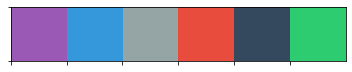

In [1]:
# Toolbox
import pandas as pd
import numpy as np
import random
import sys
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Statistics
from scipy.stats import norm

# Machine learning
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler, Normalizer
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA as sklearnPCA

# Misc
import os
import warnings
warnings.filterwarnings(action='ignore')
import tensorflow as tf

# Preset data display
pd.options.display.max_seq_items = 1000
pd.options.display.max_rows =1000
pd.set_option('display.max_columns', 50)

# Set notebook colors and palette
flatui = ['#9b59b6', '#3498db', '#95a5a6', '#e74c3c', '#34495e', '#2ecc71']
sns.set_palette(flatui)
sns.palplot(sns.color_palette(flatui))
sns.set_style('white')
sns.set_color_codes(palette='deep')
# Favorite code to use: #34995e

# Set directory
PATH = 'C:\\Users\\' + os.getlogin() + '\\Documents\\Programming\\MachineLearning\\Data'
os.chdir(PATH)
os.getcwd()
os.listdir()

wbcd = pd.read_csv('21-breast-cancer.csv')

wbcd = wbcd.iloc[:,:-1]
print("This WBCD dataset is consisted of",wbcd.shape)

train,test = train_test_split(wbcd, test_size=0.3, random_state=42)
print("Training Data :",train.shape)
print("Testing Data :",test.shape)

train_id = train['id']
test_id = test['id']

train_data = train.iloc[:,1:]
test_data = test.iloc[:,1:]

print("Training Data :",train_data.shape)
print("Testing Data :",test_data.shape)

# Training Data
train_x = train_data.iloc[:,1:]
train_x = MinMaxScaler().fit_transform(train_x)
print("Training Data :", train_x.shape)

# Testing Data
test_x = test_data.iloc[:,1:]
test_x = MinMaxScaler().fit_transform(test_x)
print("Testing Data :", test_x.shape)

# Training Data
train_y = train_data.iloc[:,:1]
train_y[train_y=='M'] = 0
train_y[train_y=='B'] = 1
print("Training Data :", train_y.shape)

# Testing Data
test_y = test_data.iloc[:,:1]
test_y[test_y=='M'] = 0
test_y[test_y=='B'] = 1
print("Testing Data :", test_y.shape)

def ann_mlp_pca():
    sklearn_pca = sklearnPCA(n_components=10)

    print("===========Data Summary===========")
    pca_train_x = sklearn_pca.fit_transform(train_x)
    print("PCA Training Data :", pca_train_x.shape)

    pca_test_x = sklearn_pca.fit_transform(test_x)
    print("PCA Testing Data :", pca_test_x.shape)

    X = tf.placeholder(tf.float32, [None,10])
    Y = tf.placeholder(tf.float32, [None, 1])

    # input
    W1 = tf.Variable(tf.random_normal([10,64], seed=0), name='weight1')
    b1 = tf.Variable(tf.random_normal([64], seed=0), name='bias1')
    layer1 = tf.nn.sigmoid(tf.matmul(X,W1) + b1)

    # hidden1
    W2 = tf.Variable(tf.random_normal([64,128], seed=0), name='weight2')
    b2 = tf.Variable(tf.random_normal([128], seed=0), name='bias2')
    layer2 = tf.nn.sigmoid(tf.matmul(layer1,W2) + b2)

    # hidden2
    W3 = tf.Variable(tf.random_normal([128,128], seed=0), name='weight3')
    b3 = tf.Variable(tf.random_normal([128], seed=0), name='bias3')
    layer3 = tf.nn.sigmoid(tf.matmul(layer2,W3) + b3)

    # output
    W4 = tf.Variable(tf.random_normal([128,1], seed=0), name='weight4')
    b4 = tf.Variable(tf.random_normal([1], seed=0), name='bias4')
    logits = tf.matmul(layer3,W4) + b4
    hypothesis = tf.nn.sigmoid(logits)

    cost_i = tf.nn.sigmoid_cross_entropy_with_logits(logits=logits,labels=Y)
    cost = tf.reduce_mean(cost_i)

    train = tf.train.GradientDescentOptimizer(learning_rate=0.01).minimize(cost)

    prediction = tf.cast(hypothesis > 0.5, dtype=tf.float32)
    correct_prediction = tf.equal(prediction, Y)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, dtype=tf.float32))

    print("\n============Processing============")
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for step in range(10001):
            sess.run(train, feed_dict={X: pca_train_x, Y: train_y})
            if step % 1000 == 0:
                loss, acc = sess.run([cost, accuracy], feed_dict={X: pca_train_x, Y: train_y})
                print("Step: {:5}\tLoss: {:.3f}\tAcc: {:.2%}".format(step, loss, acc))

        train_acc = sess.run(accuracy, feed_dict={X: pca_train_x, Y: train_y})
        test_acc,test_predict,test_correct = sess.run([accuracy,prediction,correct_prediction], feed_dict={X: pca_test_x, Y: test_y})
        
        print("\n============Results============")
        print("PCA Model Prediction =", train_acc)
        print("PCA Test Prediction =", test_acc)
        
        return train_acc,test_acc
        
ann_mlp_pca_train_acc, ann_mlp_pca_test_acc = ann_mlp_pca()

In [ ]:
train = pd.read_csv('21-breast-cancer.csv')

# Create a new feature
train['Malignant'] = np.where(train['diagnosis']=='M', 1 ,0)

accuracy_summary = [] 
loss_summary = [] 
stop_early = 0 

# Split data
y = train[['Malignant']]
X = train.drop(['id', 'diagnosis', 'Malignant', 'Unnamed: 32'], axis=1)
# X = train.drop(['id', 'diagnosis', 'Malignant', 'texture_se', 'symmetry_se', 'Unnamed: 32'], axis=1)

print('=========== Data Summary ===========')

# Split into train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=100)

# Scaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

train_x = X_train
train_y = y_train
test_x = X_test
test_y = y_test


sklearn_pca = PCA(n_components=10)

# PCA
components = 10
pca = PCA(n_components=components)

print("===========Data Summary===========")
pca_train_x = pca.fit_transform(X=train_x)
print("PCA Training Data :", pca_train_x.shape)

pca_test_x = sklearn_pca.fit_transform(test_x)
print("PCA Testing Data :", pca_test_x.shape)

# Define model parameters
LEARNING_RATE = 0.1
BATCH_SIZE = 100
EPOCHS = 5001
seed = 100

# Define input / output
number_of_inputs = components
number_of_outputs = 1

# Define layer nodes
layer_1_nodes = 64
layer_2_nodes = 128
layer_3_nodes = 128

# Create X / Y placeholders
X = tf.placeholder(tf.float32, shape=[None, number_of_inputs])
Y = tf.placeholder(tf.float32, shape=[None, number_of_outputs])

# Input layer
weights1 = tf.Variable(tf.random_normal(shape=[number_of_inputs, layer_1_nodes], seed=seed), name='weights1')
biases1 = tf.Variable(tf.random_normal(shape=[layer_1_nodes], seed=seed), name='biases1')
layer_1_output = tf.nn.sigmoid(tf.matmul(X, weights1) + biases1)

# Layer 1
weights2 = tf.Variable(tf.random_normal(shape=[layer_1_nodes, layer_2_nodes], seed=seed), name='weights2')
biases2 = tf.Variable(tf.random_normal(shape=[layer_2_nodes], seed=seed), name='biases2')
layer_2_output = tf.nn.sigmoid(tf.matmul(layer_1_output, weights2) + biases2)

# Layer 2
weights3 = tf.Variable(tf.random_normal(shape=[layer_2_nodes, layer_3_nodes], seed=seed), name='weights3')
biases3 = tf.Variable(tf.random_normal(shape=[layer_3_nodes], seed=seed), name='biases3')
layer_3_output = tf.nn.sigmoid(tf.matmul(layer_2_output, weights3) + biases3)

# Output layer
weights4 = tf.Variable(tf.random_normal(shape=[layer_3_nodes, number_of_outputs], seed=seed), name='weights4')
biases4 = tf.Variable(tf.random_normal(shape=[number_of_outputs], seed=seed), name='biases4')
logits = tf.matmul(layer_3_output, weights4) + biases4
final_output = tf.nn.sigmoid(tf.matmul(layer_3_output, weights4) + biases4) # matmul - multiplies every single node

cost_i = tf.nn.sigmoid_cross_entropy_with_logits(logits=logits,labels=Y)
cost = tf.reduce_mean(cost_i)

train = tf.train.GradientDescentOptimizer(learning_rate=0.01).minimize(cost)

prediction = tf.cast(final_output > 0.5, dtype=tf.float32)
correct_prediction = tf.equal(prediction, Y)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, dtype=tf.float32))

print("\n============Processing============")
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for step in range(10001):
        sess.run(train, feed_dict={X: pca_train_x, Y: train_y})
        if step % 1000 == 0:
            loss, acc = sess.run([cost, accuracy], feed_dict={X: pca_train_x, Y: train_y})
            print("Step: {:5}\tLoss: {:.3f}\tAcc: {:.2%}".format(step, loss, acc))

    train_acc = sess.run(accuracy, feed_dict={X: pca_train_x, Y: train_y})
    test_acc,test_predict,test_correct = sess.run([accuracy,prediction,correct_prediction], feed_dict={X: pca_test_x, Y: test_y})
    
    print("\n============Results============")
    print("PCA Model Prediction =", train_acc)
    print("PCA Test Prediction =", test_acc)

    